# Assignment 10

*Dency Claris Thomas*

*Dataset 6*

Similar as what we did in the last exercise, we would like to perform link prediction on the same
set of edges. Please choose the same edges as those in last exercise as the target of link prediction,
and train the model based on the rest of the edges. Different from the methods we used in previous
exercise, please use node2vec / DeepWalk embeddings to perform the link prediction. The node2vec
algorithm may refer to the implementation in Github: https://github.com/eliorc/node2vec, and
DeepWalk may refer to https://github.com/prateekjoshi565/DeepWalk. Please output a report
of the prediction accuracy, AUROC, precision and ROC curve.


In [1]:
import networkx as nx

facebook_edge_file = "datasets/1684.edges"
facebook_ego_graph = nx.read_edgelist(facebook_edge_file)

print(f"Number of nodes: {facebook_ego_graph.number_of_nodes()}")
print(f"Number of edges: {facebook_ego_graph.number_of_edges()}")

Number of nodes: 157
Number of edges: 569


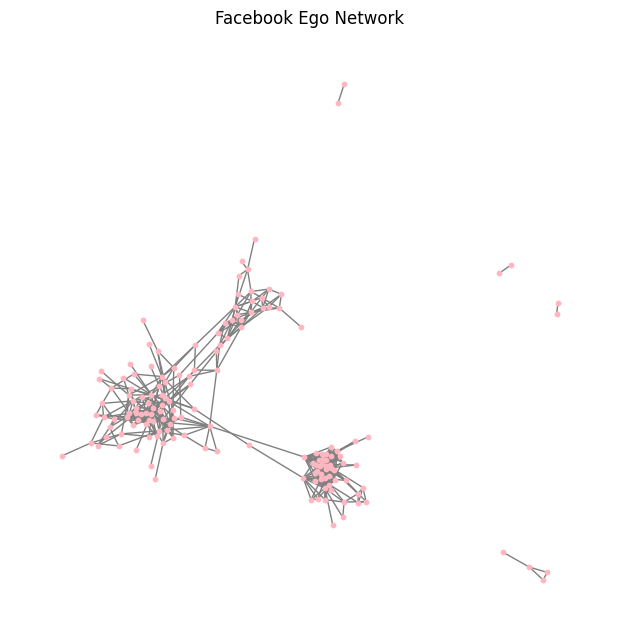

In [2]:
import matplotlib.pyplot as plt

# Plot the Network
plt.figure(figsize=(6,6))
nx.draw(facebook_ego_graph, with_labels = False, node_size = 10, node_color = 'lightpink', edge_color = 'gray')
plt.title('Facebook Ego Network')
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve, auc
import numpy as np
from node2vec import Node2Vec


c:\Users\dency\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Randomly remove 10% of the edges for testing
edges = list(facebook_ego_graph.edges())
edges_train, edges_test = train_test_split(edges, test_size=0.1, random_state=42)

# Remove the test edges from the graph
facebook_ego_train = facebook_ego_graph.copy()
facebook_ego_train.remove_edges_from(edges_test)

In [5]:
# Add negative (non-existent) edges for training and testing
all_possible_edges = list(nx.non_edges(facebook_ego_graph))
negative_edges = np.random.choice(len(all_possible_edges), len(edges_test), replace=False)
negative_edges = [all_possible_edges[i] for i in negative_edges]

# Split negative edges into train and test sets
negative_train_edges, negative_test_edges = train_test_split(negative_edges, test_size=0.1, random_state=42)

# Prepare training and test data
train_edges = edges_train + negative_train_edges
train_labels = [1] * len(edges_train) + [0] * len(negative_train_edges)

test_edges = edges_test + negative_test_edges
test_labels = [1] * len(edges_test) + [0] * len(negative_test_edges)

In [6]:
# Validate lengths
print(f"Length of train_edges: {len(train_edges)}")
print(f"Length of train_labels: {len(train_labels)}")

Length of train_edges: 563
Length of train_labels: 563


In [7]:
# Node2Vec embeddings
node2vec = Node2Vec(facebook_ego_train, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 157/157 [00:00<00:00, 4961.17it/s]


In [8]:
# Generate features for link prediction
def get_edge_features(edge_list, model):
    edge_features = []
    for u, v in edge_list:
        if u in model.wv and v in model.wv:
            edge_features.append(model.wv[u] * model.wv[v])  # Element-wise product of node embeddings
        else:
            edge_features.append(np.zeros(model.vector_size))
    return np.array(edge_features)

In [9]:
X_train = get_edge_features(train_edges, model)
X_test = get_edge_features(test_edges, model)

In [10]:
# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, train_labels)

# Evaluate the model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [11]:
accuracy = accuracy_score(test_labels, y_pred)
auroc = roc_auc_score(test_labels, y_proba)
precision = precision_score(test_labels, y_pred)
fpr, tpr, _ = roc_curve(test_labels, y_proba)
roc_auc = auc(fpr, tpr)

# Output the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.9365
AUROC: 0.9825
Precision: 0.9818


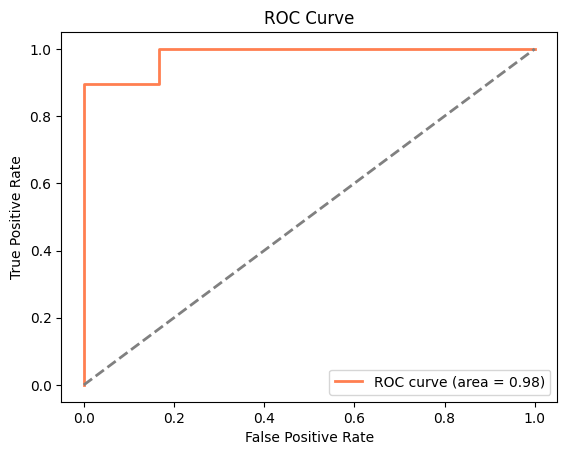

In [12]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='coral', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()